# Fashion Mnist Image Analysis 

In this notebook we will be exploring and creating a deep learning model using the tensorflow dataset, fashion_mnist. This dataset consists of a training set of 60,000 samples and test set of 10,000 samples. These samples are in a 28x28 greyscale image associated with 1 of 10 classes. I will be creating a model utilizing a Convolutional Neural Network to predict the class. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random
import tensorflow as tf
import keras
from tensorflow import keras
import keras_tuner as kt

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
train_images  = train_images / 255.0
test_images = test_images / 255.0

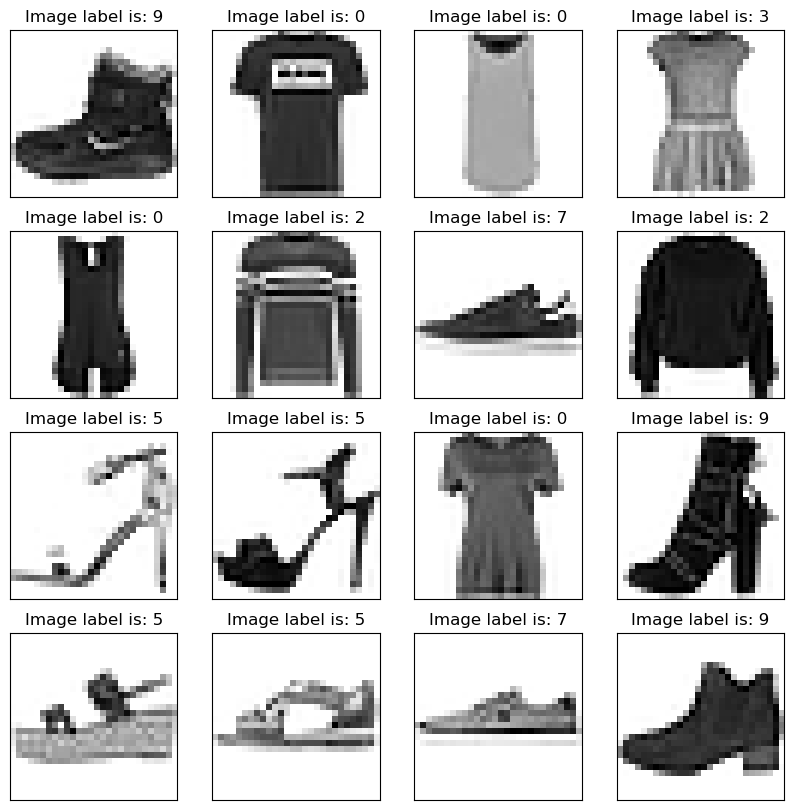

In [4]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(train_labels[i]))
plt.show()

In [5]:
x_train = train_images.reshape(-1,28,28,1)
x_test = test_images.reshape(-1,28,28,1)

In [6]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## Model

In [7]:
def build_model(hp):
    model = keras.Sequential([
        
    # First conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_1_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
        activation='relu',
        input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),
    
    # Second conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_2_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
        activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    # --------------------------------
    keras.layers.Flatten(),
    keras.layers.Dense(units = hp.Choice('units', values=[16, 32, 64, 128, 256]),
                       activation='relu'),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
        
    # --------------------------------
    keras.layers.Dense(10)
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                            values=[1e-1, 1e-2, 1e-3, 1e-4])),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [8]:
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     hyperband_iterations=3)

Reloading Tuner from .\untitled_project\tuner0.json


In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
conv_1_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
conv_2_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [10]:
tuner.search(x_train,train_labels, epochs=3, validation_split=0.2)

In [11]:
best_hps = best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""conv_1_filter is {best_hps.get('conv_1_filter')}""")
print(f"""conv_1_kernel is {best_hps.get('conv_1_kernel')}""")
print(f"""conv_2_filter is {best_hps.get('conv_2_filter')}""")
print(f"""conv_2_kernel is {best_hps.get('conv_2_kernel')}""")
print("-------------------------------------------------")
print(f"""units is {best_hps.get('units')}""")
print(f"""learning_rate is {best_hps.get('learning_rate')}""")
print(f"""dropout is {best_hps.get('dropout')}""")

conv_1_filter is 16
conv_1_kernel is 3
conv_2_filter is 128
conv_2_kernel is 4
-------------------------------------------------
units is 128
learning_rate is 0.001
dropout is 0.2


In [12]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, train_labels, 
                    epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

C:\Users\kvedh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7577 - loss: 0.6733 - val_accuracy: 0.8814 - val_loss: 0.3227
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8861 - loss: 0.3150 - val_accuracy: 0.9027 - val_loss: 0.2675
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9020 - loss: 0.2717 - val_accuracy: 0.9078 - val_loss: 0.2545
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9183 - loss: 0.2274 - val_accuracy: 0.9103 - val_loss: 0.2491
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9287 - loss: 0.1989 - val_accuracy: 0.9120 - val_loss: 0.2442
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9355 - loss: 0.1753 - val_accuracy: 0.9153 - val_loss: 0.2346
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9427 - loss: 0.1554 - val_accuracy: 0.9193 - val_loss: 0.2328
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9478 - loss: 0.1387 - 

In [13]:
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(x_train, train_labels, 
                         epochs=best_epoch, 
                         validation_split=0.2, 
                         callbacks=[early_stop])

Epoch 1/13
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7550 - loss: 0.6798 - val_accuracy: 0.8853 - val_loss: 0.3151
Epoch 2/13
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8872 - loss: 0.3109 - val_accuracy: 0.8938 - val_loss: 0.2916
Epoch 3/13
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9046 - loss: 0.2550 - val_accuracy: 0.9104 - val_loss: 0.2474
Epoch 4/13
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9184 - loss: 0.2204 - val_accuracy: 0.9061 - val_loss: 0.2603
Epoch 5/13
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9282 - loss: 0.1919 - val_accuracy: 0.9142 - val_loss: 0.2329
Epoch 6/13
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9370 - loss: 0.1682 - val_accuracy: 0.9152 - val_loss: 0.2299
Epoch 7/13
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9458 - loss: 0.1491 - val_accuracy: 0.9177 - val_loss: 0.2280
Epoch 8/13
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9513 - loss: 0.1300 - 

In [14]:
hypermodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,224 (5.08 MB)

 Trainable params: 444,074 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 888,150 (3.39 MB)

In [16]:
eval_result = hypermodel.evaluate(x_test, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9154 - loss: 0.2706
[test loss, test accuracy]: [0.2630535364151001, 0.917900025844574]


In [17]:
pred = hypermodel.predict(x_test)

print("Prediction is -> {}".format(pred[12]))
print("Actual value is -> {}".format(test_labels[12]))
print("The highest value for label is {}".format(np.argmax(pred[12])))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Prediction is -> [ -5.0253816  -11.101304    -8.160847   -11.923498   -10.384344
   4.632245   -14.644898     8.296317     0.77435344   1.3389636 ]
Actual value is -> 7
The highest value for label is 7


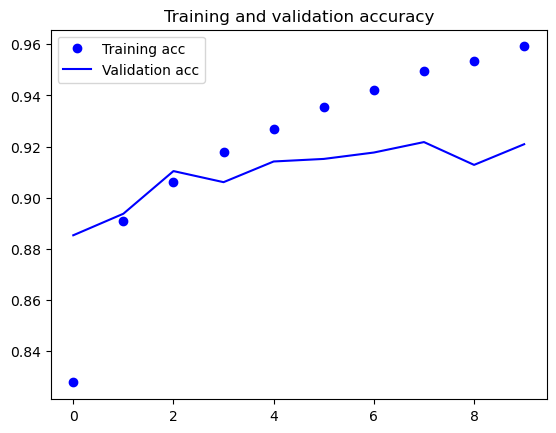

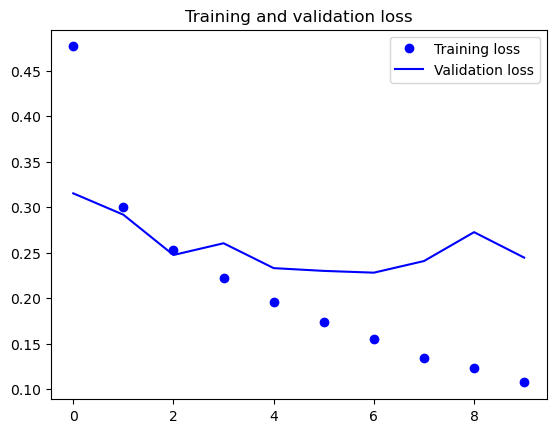

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Discussion

I reached an accuracy of 91.8%. My model consisted of 2 convolution layers with a 3x4 feature map size, which are each followed by a max pooling layer to reduce the dimensionality of the features. I then flattened this and added a dense later with activation relu. A dropout layer is then added to reduce overfitting. This was set to randomly disable 20% of the neurons. I then added 1 more dense layer. 

The validation accuracy and loss diagrams above indicate that this model performs very well. We want to maximize the validation accuracy and minimize the validation loss, which can be seen at around epoch 6. 